## Load MNIST WAE model

In [24]:
import os, sys, time, logging
sys.path.append('/'.join(os.getcwd().split('/')))
import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES']='1'
from SAE.dataset import MNIST
from SAE.dataset import CelebA
from SAE.SAE import WAE_MMD_abstract
from SAE.util import init_params, gaus

import torch
import torch.nn as nn
import torch.optim as optim
from exp_mnist.train_base.train import WAE_MMD_MNIST

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

data_home = '/home/reddragon/data/MNIST'
train_data = MNIST(data_home, train = True)
test_data = MNIST(data_home, train = False)

log = None
# logger = logging_daily('./exp_mnist/config/log_info.yaml')
# log = logger.get_logging()
# log.setLevel(logging.INFO)

In [6]:
network_info = {
    'train':{
        'z_sampler':gaus,
        'train_data':train_data,
        'test_data':test_data,
        'batch_size':100,
        'z_dim':8,

        'encoder_pretrain':False,
        'encoder_pretrain_batch_size':1000,
        'encoder_pretrain_max_step':200,

        'lr':1e-4,
        'beta1':0.9,
        'lambda':10.0,

        'lr_schedule':"manual",
        'eps':1.0,
        'L':40,
        'validate':True,
        'histogram':True,

        'epoch':100,
        'iter_per_epoch':None,
    },
    'path':{
        'save_best':False,
        'save_path':'./weight.pt',
        'tb_logs':'../tb_logs/wae_mnist-base'
    }
}

wae_MMD = WAE_MMD_MNIST(network_info, log, device = device, verbose = 0)
wae_MMD.load('exp_mnist/train_base/weight.pt')

### Reconstruction from test set

In [34]:
test_generator = torch.utils.data.DataLoader(test_data, 32, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
test_sample = next(iter(test_generator))
recon_sample = wae_MMD(test_sample.to(device)).to('cpu').detach().numpy()

In [42]:
test_sample = np.array(test_sample)
ghx = []
for i in range(4):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(4):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

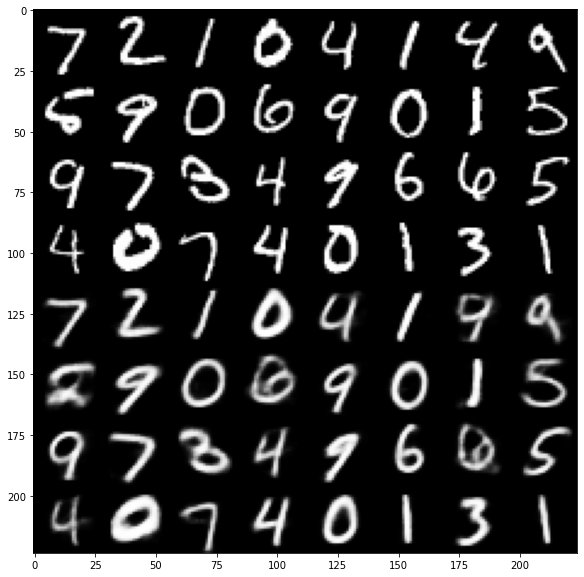

In [43]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show()

### Generation from prior distribution

In [44]:
Z = gaus(64, 8).to(device)
gen_sample = wae_MMD.dec(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(8):
    gz.append(np.concatenate([gen_sample[8*i + j,0,:,:] for j in range(8)], axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

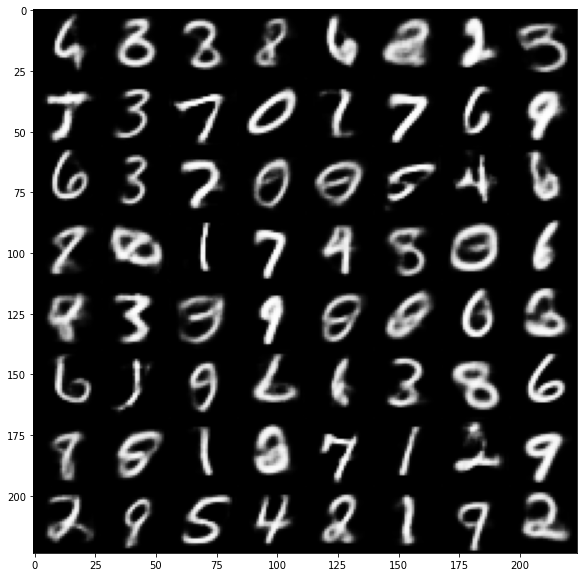

In [45]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(generation_result, cmap='gray', vmin=-1, vmax=1)
plt.show()

## Load CelebA WAE model

In [49]:
import os, sys, time, logging
sys.path.append('/'.join(os.getcwd().split('/')))
import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES']='1'
from SAE.dataset import MNIST
from SAE.dataset import CelebA
from SAE.SAE import WAE_MMD_abstract
from SAE.util import init_params, gaus

import torch
import torch.nn as nn
import torch.optim as optim

from exp_celebA.train_base.train import WAE_MMD_celebA

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

data_home = '/home/reddragon/data/celebA'
train_data = CelebA(data_home, 'x_list_train.npy')
test_data = CelebA(data_home, 'x_list_test.npy')

log = None
# logger = logging_daily('./exp_mnist/config/log_info.yaml')
# log = logger.get_logging()
# log.setLevel(logging.INFO)

In [50]:
network_info = {
    'train':{
        'z_sampler':gaus,
        'train_data':train_data,
        'test_data':test_data,
        'batch_size':100,
        'z_dim':64,

        'encoder_pretrain':False,
        'encoder_pretrain_batch_size':1000,
        'encoder_pretrain_max_epoch':20,

        'lr':1e-3,
        'beta1':0.5,
        'lambda':100.0,

        'lr_schedule':"manual",
        'eps':1.0,
        'L':40,
        'validate':True,
        'histogram':True,

        'epoch':55,
        'iter_per_epoch':None,
    },
    'path':{
        'save_best':False,
        'save_path':'./weight.pt',
        'tb_logs':'../tb_logs/wae_celebA-base'
    }
}

wae_MMD = WAE_MMD_celebA(network_info, log, device = device, verbose = 0)
wae_MMD.load('exp_celebA/train_base/weight.pt')

### Reconstruction from test set

In [51]:
test_generator = torch.utils.data.DataLoader(test_data, 32, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
test_sample = next(iter(test_generator))
recon_sample = wae_MMD(test_sample.to(device)).to('cpu').detach().numpy()

In [65]:
test_sample = np.array(test_sample)
ghx = []
for i in range(4):
    ghx.append(np.concatenate([test_sample[8*i+j,:,:,:] for j in range(8)], axis = 2))
for i in range(4):
    ghx.append(np.concatenate([recon_sample[8*i+j,:,:,:] for j in range(8)], axis = 2))
recon_results = (np.concatenate(ghx, axis = 1) + 1)/2 # concatenate matrix for plt

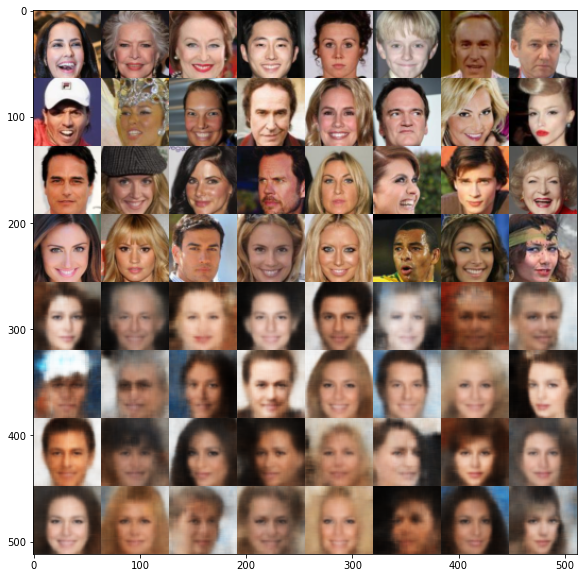

In [66]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results.transpose(1,2,0))
plt.show()

### Generation from prior distribution

In [72]:
Z = gaus(64, 64).to(device)
gen_sample = wae_MMD.dec(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(8):
    gz.append(np.concatenate([gen_sample[8*i + j,:,:,:] for j in range(8)], axis = 2))
generation_result = (np.concatenate(gz, axis = 1) + 1)/2 # concatenate matrix for plt

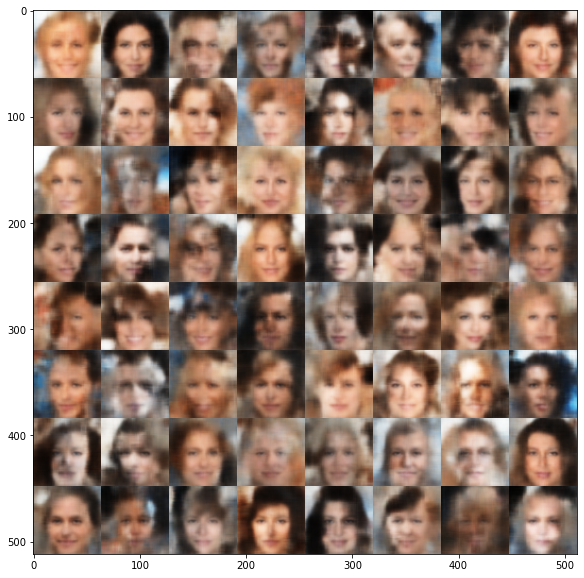

In [73]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(generation_result.transpose(1,2,0))
plt.show()